Import the essential libraries

In [6]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
#import rasterio
#from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming you have y_true and y_pred as the true and predicted labels


# For visualization of plots without plt.show()
%matplotlib inline

In [3]:
import sklearn
print(sklearn.__version__)


1.3.0


In [8]:
tf.__version__

'2.13.0'

Define the required variable

In [7]:
dataset_url = r'C:\Users\sumit\Downloads\IIT J Sem Notes\Sem 3\MTP Remote sensing\EuroSAT\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

Data preparation for the model

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [10]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [11]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


Visualization of input datasets

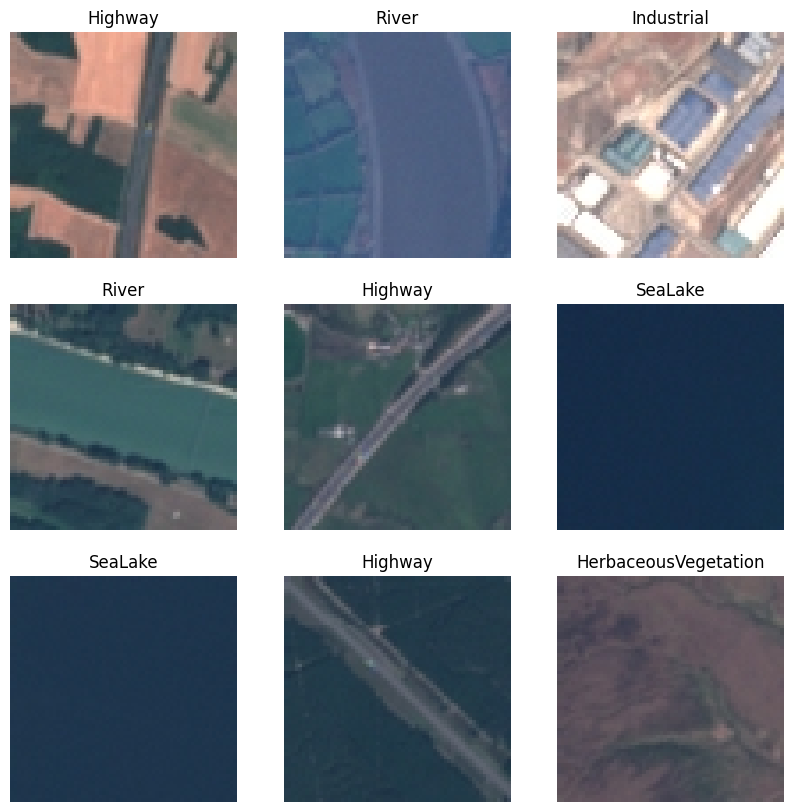

In [12]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

ResNet50 Model building

In [13]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [14]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


In [15]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model


Model train

In [16]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']          

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:

history = model.fit(train_dataset, validation_data=test_dataset, epochs=5, batch_size=32)

Epoch 1/5
675/675 [==============================] - 2386s 4s/step - loss: 1.3971 - accuracy: 0.5658 - val_loss: 1.6156 - val_accuracy: 0.5819
Epoch 2/5
675/675 [==============================] - 1750s 3s/step - loss: 0.9137 - accuracy: 0.7006 - val_loss: 0.7694 - val_accuracy: 0.7420
Epoch 3/5
675/675 [==============================] - 4327s 6s/step - loss: 0.7928 - accuracy: 0.7422 - val_loss: 1.0579 - val_accuracy: 0.6483
Epoch 4/5
675/675 [==============================] - 1461s 2s/step - loss: 0.6804 - accuracy: 0.7771 - val_loss: 0.8351 - val_accuracy: 0.7507
Epoch 5/5
675/675 [==============================] - 1441s 2s/step - loss: 0.8234 - accuracy: 0.7656 - val_loss: 1.8340 - val_accuracy: 0.6109


In [22]:
model.save(r'model/model_5_epoch.h5')

c:\Users\sumit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Load Model

In [23]:
from tensorflow.keras.models import load_model
model = load_model(r'model/model_5_epoch.h5')

Analyzing the Model

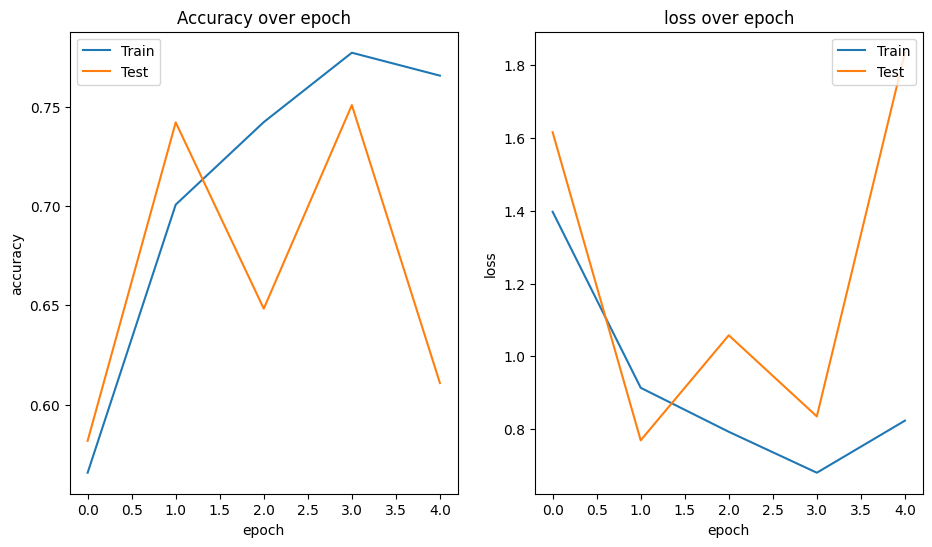

In [25]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(11,6))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train','Test'],loc='upper left')


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('loss over epoch')
ax2.legend(['Train','Test'],loc='upper right')

Confusion Maxtrix

In [26]:
y_pred = []
y_true=[]

for i, (image_batch,label_batch) in enumerate(test_dataset):
    y_true.append(label_batch)
    preds= model.predict(image_batch)
    y_pred.append(np.argmax(preds,axis=1))
    if i==300:
        break
correct_labels = tf.concat([item for item in y_true],axis=0)
correct_labels= np.argmax(correct_labels,axis=1)
predicted_labels= tf.concat([item for item in y_pred],axis=0)    

1/1 [==============================] - 0s 342ms/step


In [27]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[828,  13,  42,  41,   7,  17,  18,  35,  46,  13],
       [  3, 938,  27,   0,   0,  27,   0,   0,   6,  77],
       [113,  21, 421,  50,  22,  48,  57, 237,  60,  26],
       [110,   3,  26, 349,  49,  15,   7,  81, 243,   1],
       [  5,   0,   0,  52, 760,   0,   0,  74,  15,   0],
       [146,  68,  15,   7,   1, 307,   5,  38, 107,  25],
       [275,   0, 144,  70,  30,  51, 120, 149,  54,   0],
       [  9,   3,  12,  74,  69,  42,   9, 769,  84,   3],
       [ 65,  24,  15,  67,  13,  37,   3,  30, 618,   9],
       [ 17, 155,  35,   2,   0,  10,   0,  17,  23, 815]], dtype=int64)

In [35]:
def plot_confusion_matrix(cm,classes,normalize= False, title= 'Confusion_matrix',figsize=(8,8),cmap=plt.cm.Blues):

    plt.figure(figsize=figsize)
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm =cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else: 
        print('Confusion matrix, without normalization')
    print(cm) 

    thresh= cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment="center",
                 color= "white" if cm[i,j]> thresh else "black")
               
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted_labels')


Confusion matrix, without normalization
[[828  13  42  41   7  17  18  35  46  13]
 [  3 938  27   0   0  27   0   0   6  77]
 [113  21 421  50  22  48  57 237  60  26]
 [110   3  26 349  49  15   7  81 243   1]
 [  5   0   0  52 760   0   0  74  15   0]
 [146  68  15   7   1 307   5  38 107  25]
 [275   0 144  70  30  51 120 149  54   0]
 [  9   3  12  74  69  42   9 769  84   3]
 [ 65  24  15  67  13  37   3  30 618   9]
 [ 17 155  35   2   0  10   0  17  23 815]]


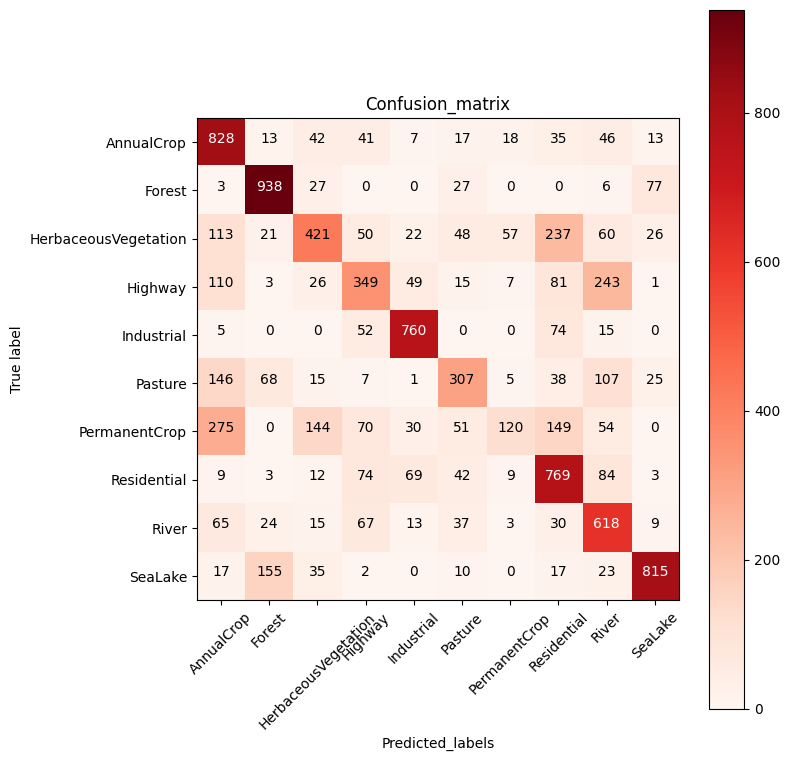

In [36]:
plot_confusion_matrix(cm,train_dataset.class_indices, cmap='Reds')